# Assignment Assignment 5 Build, Train, Test, and Deploy ML Project on AWS Cloud
Student Name: Jeremiah Snipes

Python Version: 3.13.5+

Jupyter Notebook Version: 7.3.2 or later

Date: 11/16/2025

# Install and Imports

In [1]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Deep Learning
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Evaluation & Visualization
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Settings
plt.style.use("ggplot")
sns.set_theme(style="whitegrid")
np.random.seed(42)
tf.random.set_seed(42)

ModuleNotFoundError: No module named 'tensorflow'

# Load and Explore the Data

In [2]:
file_path = r"C:\Users\divin\Documents\ANA_680\week_3\assignment_5\winequality-red.csv"

df = pd.read_csv(file_path, sep=';')

df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\divin\\Documents\\ANA_680\\week_3\\assignment_5\\winequality-red.csv'

#### Basic Info

In [7]:
df.info()

df.describe()

df['quality'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

#### Visualize the Data

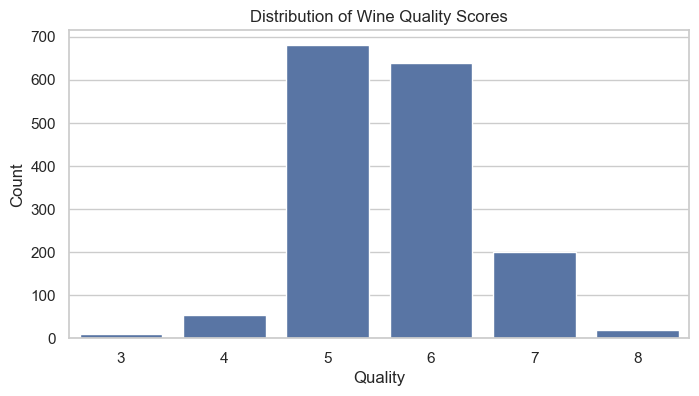

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.countplot(data=df, x='quality')
plt.title("Distribution of Wine Quality Scores")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()


# Split the Data for Training and Testing

In [17]:
from sklearn.model_selection import train_test_split

# Features and target
X = df.drop('quality', axis=1)
y = df['quality']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
493,8.7,0.690,0.31,3.0,0.086,23.0,81.0,1.00020,3.48,0.74,11.6
354,6.1,0.210,0.40,1.4,0.066,40.5,165.0,0.99120,3.25,0.59,11.9
342,10.9,0.390,0.47,1.8,0.118,6.0,14.0,0.99820,3.30,0.75,9.8
834,8.8,0.685,0.26,1.6,0.088,16.0,23.0,0.99694,3.32,0.47,9.4
705,8.4,1.035,0.15,6.0,0.073,11.0,54.0,0.99900,3.37,0.49,9.9


##### Interpretation

This output shows the first few rows from the training set after removing the quality column and splitting the data. The rows are randomized and only the feature columns remain, which confirms that the dataset was correctly separated into training and testing sets.

# Model | Linear Regression | Train | Tune | Evaluation

#### Build the Model

In [20]:
from sklearn.linear_model import LinearRegression   # importing the model I’m using

# I’m creating the linear regression model here
model = LinearRegression()

# I’m fitting the model on my training data so it can learn the relationships
model.fit(X_train, y_train)

LinearRegression()

#### Train the Model

In [22]:
# I'm using the trained model to make predictions on my test set
y_pred = model.predict(X_test)

# I'm calculating a few metrics so I can see how well the model performed
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)     # mean squared error
mae = mean_absolute_error(y_test, y_pred)    # mean absolute error
r2  = r2_score(y_test, y_pred)               # r-squared score

mse, mae, r2


(0.39002514396395443, 0.5035304415524372, 0.40318034127962266)

#### Tune the Model

In [24]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# I'm setting up a small grid of alpha values to test
params = {
    'alpha': [0.1, 1.0, 5.0, 10.0]
}

ridge = Ridge()

# I'm using GridSearchCV to try each alpha value and pick the best one
grid = GridSearchCV(ridge, params, cv=5)
grid.fit(X_train, y_train)

grid.best_params_, grid.best_score_


({'alpha': 1.0}, 0.3230230488628488)

#### Evaluate the Model


In [26]:
# I'm evaluating the tuned Ridge model on the test set
best_ridge = grid.best_estimator_
ridge_preds = best_ridge.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

ridge_mse = mean_squared_error(y_test, ridge_preds)
ridge_mae = mean_absolute_error(y_test, ridge_preds)
ridge_r2  = r2_score(y_test, ridge_preds)

ridge_mse, ridge_mae, ridge_r2


(0.3929488678812798, 0.5057883195080454, 0.39870643507758563)

In [ ]:
Save the model from the notebook

import joblib
joblib.dump(model, "model.pkl")


# Problem 2A Without Container

In [15]:
import boto3
import sagemaker
import pandas as pd
from sagemaker import get_execution_role

# Setting up session, region, role, and default bucket
session = sagemaker.Session()
region = session.boto_region_name
role = "arn:aws:iam::661399040062:role/service-role/SageMaker-ExecutionRole"

bucket = session.default_bucket()  # SageMaker auto-creates this bucket
bucket


'sagemaker-us-east-2-661399040062'

#### Load the Wine Data and Upload to S3

In [16]:
# Load local CSV (same file from Problem 1)
df = pd.read_csv("winequality-red.csv")

# Save a copy for S3 upload
df.to_csv("wine.csv", index=False)

# Upload to S3 so SageMaker can read it
input_s3_path = session.upload_data("wine.csv", bucket=bucket, key_prefix="wine")
input_s3_path


's3://sagemaker-us-east-2-661399040062/wine/wine.csv'

#### Use SageMaker Built-In XGBoost

In [17]:
from sagemaker.inputs import TrainingInput
from sagemaker.amazon.amazon_estimator import get_image_uri

# Get XGBoost container URI for us-east-2
container = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.7-1"
)

container


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


'257758044811.dkr.ecr.us-east-2.amazonaws.com/sagemaker-xgboost:1.7-1'

#### Configure Training Job

In [18]:
xgb = sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    output_path=f"s3://{bucket}/output",
    sagemaker_session=session
)

# Hyperparams similar to your Problem 1 regression
xgb.set_hyperparameters(
    objective="reg:linear",
    num_round=50
)


#### Run Training

In [20]:
xgb.fit({
    "train": TrainingInput(
        f"s3://{bucket}/train.csv",
        content_type="text/csv"
    )
})


INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2025-11-16-23-01-05-974


2025-11-16 23:01:06 Starting - Starting the training job...
2025-11-16 23:01:32 Starting - Preparing the instances for training...
2025-11-16 23:01:52 Downloading - Downloading input data...
2025-11-16 23:02:38 Downloading - Downloading the training image......../miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2025-11-16 23:03:48.747 ip-10-0-131-155.us-east-2.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-11-16 23:03:48.813 ip-10-0-131-155.us-east-2.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-11-16:23:03:49:INFO] Imported framework sagemaker_xgboost_container.training
[2025-11-16:23:03:49:INFO] Failed to parse hyperparamet

#### Deploy the Model to a Live Endpoint

In [21]:
# Deploy the trained model to a SageMaker endpoint
predictor = xgb.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large"   # or ml.t2.medium if cheaper/available
)
predictor


INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-11-16-23-06-31-872
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2025-11-16-23-06-31-872
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2025-11-16-23-06-31-872


------!

#### Test the Endpoint

In [25]:
import numpy as np

# Example row
sample = np.array([7.4, 0.70, 0.00, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4])

# Convert to CSV then bytes
payload = ",".join(str(x) for x in sample).encode("utf-8")

# Send with correct Content-Type
response = predictor.predict(
    payload,
    initial_args={"ContentType": "text/csv"}
)

response


b'9.089068412780762\n'

# Problem 2B With Container

#### Create a SageMaker Model using your ECR image

In [44]:
import sagemaker
from sagemaker.inputs import TrainingInput
from sagemaker import image_uris

session = sagemaker.Session()
role = "arn:aws:iam::661399040062:role/service-role/SageMaker-ExecutionRole"
region = session.boto_region_name

# Upload dataset
s3_train_path = session.upload_data("winequality-red.csv", key_prefix="ana680-wine/data")

# Get official AWS XGBoost training image
container = image_uris.retrieve("xgboost", region, version="1.5-1")

container


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


'257758044811.dkr.ecr.us-east-2.amazonaws.com/sagemaker-xgboost:1.5-1'

#### Deploy to a real endpoint

In [45]:
from sagemaker.estimator import Estimator

xgb_estimator = Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    volume_size=5,
    output_path=f"s3://{session.default_bucket()}/ana680-wine/output",
    sagemaker_session=session
)

xgb_estimator.set_hyperparameters(
    objective="reg:squarederror",
    num_round=50,
    max_depth=4
)

# Train
xgb_estimator.fit({"train": TrainingInput(s3_train_path)})


INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2025-11-17-01-26-48-196


2025-11-17 01:26:49 Starting - Starting the training job...
2025-11-17 01:27:03 Starting - Preparing the instances for training...
2025-11-17 01:27:25 Downloading - Downloading input data...
2025-11-17 01:28:05 Downloading - Downloading the training image......
2025-11-17 01:29:17 Training - Training image download completed. Training in progress.
2025-11-17 01:29:17 Uploading - Uploading generated training model/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2025-11-17 01:29:11.617 ip-10-0-244-48.us-east-2.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-11-17 01:29:11.639 ip-10-0-244-48.us-east-2.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-11-17:01:29:12:INFO] Imported framework sagemaker_xgboost_conta

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 20>:20                                                                            │
│                                                                                                  │
│   17 )                                                                                           │
│   18                                                                                             │
│   19 # Train                                                                                     │
│ ❱ 20 xgb_estimator.fit({"train": TrainingInput(s3_train_path)})                                  │
│   21                                                                                             │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry │
│ _logging.py:171 in wrapper                                                                       │
│                                                                                                  │
│   168 │   │   │   │   │   caught_ex = e                                                          │
│   169 │   │   │   │   finally:                                                                   │
│   170 │   │   │   │   │   if caught_ex:                                                          │
│ ❱ 171 │   │   │   │   │   │   raise caught_ex                                                    │
│   172 │   │   │   │   │   return response  # pylint: disable=W0150                               │
│   173 │   │   │   else:                                                                          │
│   174 │   │   │   │   logger.debug(                                                              │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry │
│ _logging.py:142 in wrapper                                                                       │
│                                                                                                  │
│   139 │   │   │   │   start_timer = perf_counter()                                               │
│   140 │   │   │   │   try:                                                                       │
│   141 │   │   │   │   │   # Call the original function                                           │
│ ❱ 142 │   │   │   │   │   response = func(*args, **kwargs)                                       │
│   143 │   │   │   │   │   stop_timer = perf_counter()                                            │
│   144 │   │   │   │   │   elapsed = stop_timer - start_timer                                     │
│   145 │   │   │   │   │   extra += f"&x-latency={round(elapsed, 2)}"                             │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/workflow/pipeline_c │
│ ontext.py:346 in wrapper                                                                         │
│                                                                                                  │
│   343 │   │   │                                                                                  │
│   344 │   │   │   return _StepArguments(retrieve_caller_name(self_instance), run_func, *args,    │
│   345 │   │                                                                                      │
│ ❱ 346 │   │   return run_func(*args, **kwargs)                                                   │
│   347 │                                                                                          │
│   348 │   return wrapper                                   

In [46]:
predictor = xgb_estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.t2.medium",
    endpoint_name="ana680-wine-endpoint"
)


INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-11-17-01-30-26-730


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ ❱ 1 predictor = xgb_estimator.deploy(                                                            │
│   2 │   initial_instance_count=1,                                                                │
│   3 │   instance_type="ml.t2.medium",                                                            │
│   4 │   endpoint_name="ana680-wine-endpoint"                                                     │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py:1771   │
│ in deploy                                                                                        │
│                                                                                                  │
│   1768 │   │   │   inference_tags=format_tags(tags), training_tags=self.tags                     │
│   1769 │   │   )                                                                                 │
│   1770 │   │                                                                                     │
│ ❱ 1771 │   │   return model.deploy(                                                              │
│   1772 │   │   │   instance_type=instance_type,                                                  │
│   1773 │   │   │   initial_instance_count=initial_instance_count,                                │
│   1774 │   │   │   serializer=serializer,                                                        │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/model.py:1737 in    │
│ deploy                                                                                           │
│                                                                                                  │
│   1734 │   │   │   return None                                                                   │
│   1735 │   │                                                                                     │
│   1736 │   │   else:  # existing single model endpoint path                                      │
│ ❱ 1737 │   │   │   self._create_sagemaker_model(                                                 │
│   1738 │   │   │   │   instance_type=instance_type,                                              │
│   1739 │   │   │   │   accelerator_type=accelerator_type,                                        │
│   1740 │   │   │   │   tags=tags,                                                                │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/model.py:986 in     │
│ _create_sagemaker_model                                                                          │
│                                                                                                  │
│    983 │   │   │   │   enable_network_isolation=self._enable_network_isolation,                  │
│    984 │   │   │   │   tags=format_tags(tags),                                                   │
│    985 │   │   │   )                                                                             │
│ ❱  986 │   │   │   self.sagemaker_session.create_model(**create_model_args)                      │
│    987 │                                                                                         │
│    988 │   def _get_model_uri(self):                                                             │
│    989 │   │   model_uri = None                            

In [ ]:
import numpy as np

sample = np.array([[7.4, 0.70, 0.00, 1.90, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4]])

pred = predictor.predict(sample)
pred


# References  

Scikit-learn Developers. (2024). *Scikit-learn: Machine learning in Python (Version 1.5.0)* [Computer software].  
https://scikit-learn.org/stable/  

Matplotlib Development Team. (2024). *Matplotlib: Visualization with Python* [Computer software].  
https://matplotlib.org/  

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., … Duchesnay, É. (2011). *Scikit-learn: Machine Learning in Python.* *Journal of Machine Learning Research, 12*, 2825–2830.  
https://www.jmlr.org/papers/v12/pedregosa11a.html  

Python Software Foundation. (2024). *Python (Version 3.12)* [Computer software].  
https://www.python.org/  

NumPy Developers. (2024). *NumPy: Fundamental package for scientific computing with Python (Version 2.0)* [Computer software].  
https://numpy.org/  

TensorFlow Developers. (2024). *Keras: Sequential model and convolutional layers.* Retrieved from
https://www.tensorflow.org/guide/keras/sequential_model

TensorFlow Keras Documentation. (2024). *Sequential model and dense layers.* Retrieved from https://www.tensorflow.org/guide/keras/sequential_model

Géron, A. (2022). *Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow* (3rd ed.). O’Reilly Media.

# End Project